In [1]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-

"""
Application de la méthode de Galerkine aux données
"""

DataFolder="C:/Users/Julie_000/Desktop/Stage/Stage_l3"

# Importations des librairies

In [2]:
from mat4py import loadmat #pour charger des .mat
import matplotlib.pyplot as plt # pour tracer les figures
import os # pour modifier le dossier de travail
import numpy as np 
from pathlib import Path # Pour rendre les Path compatibles entre Mac et Windows
from matplotlib import rc #Les trois prochaines lignes pour que Ã§a ressemble Ã  latex
rc('font', size=16)
rc('text', usetex=True)
import scipy as sc
import matplotlib.cm as cm #colormaps
from matplotlib.colors import Normalize #Pour l'utilisation des couleurs dans quiver
from matplotlib.ticker import MaxNLocator #pour les courbes de niveau
from scipy.ndimage import gaussian_filter #Filtrage gaussien

from scipy.linalg import pinv as scpinv
from numpy.linalg import pinv as nppinv

import fonctions_projet_divergence as fpd#pour les données

colormap2=cm.PiYG#colormap

# Chargement des données
## Définition des fonctions

In [3]:
def PIV(prof,manips): 
    """retourne les données des plans pour la bonne profondeur"""
    if prof==5:
        piv=manips['piv5']
    elif prof==10:
        piv=manips['piv10']
    elif prof==15:
        piv=manips['piv15']
    else:
        return("prof n'a pas une valeur acceptable")   
    return(piv)

def nb_plan(prof):
    "Détermine le nombre de plan pour une profondeur donnée"
    if prof==5:
        return(16)
    if prof==10:
        return(32)
    if prof==15:
        return(49)
    else:
        return("prof n'a pas une valeur acceptable")
    
def donnees(n,piv):
    "Charge les données pour la profondeur donnée"
    u=np.zeros((n,60,60))
    v=np.zeros((n,60,60))
    x=np.zeros((n,60,60))
    y=np.zeros((n,60,60))
    z=np.zeros((n))

    for plan in range(n): 
            u[plan]=np.array(piv[plan]['u'])
            v[plan]=np.array(piv[plan]['v'])
            x[plan]=np.array(piv[plan]['x'])
            y[plan]=np.array(piv[plan]['y'])
            z[plan]=np.array(piv[plan]['prof'])
    return(u,v,x,y,z)

## Choix de la profondeur de travail

In [4]:
prof=10 # Choisi sur quelle profondeur d'eau travailler (5, 10 ou 15 mm)

## Chargement des données

In [5]:
os.chdir(Path(DataFolder)) # se place dans le dossier où est rangée la manip
manips=loadmat('PIVnagseul.mat') # Charge les données dans la variable manip

piv=PIV(prof,manips)#données pour la profondeur

P=nb_plan(prof)#nombre de plan dans la profondeur choisie

u,v,x,y,z=donnees(P,piv)
print(np.shape(u),np.shape(v),np.shape(x),np.shape(y),np.shape(z))

(32, 60, 60) (32, 60, 60) (32, 60, 60) (32, 60, 60) (32,)


# Application du programme de divergence bidimensionnelle
## Fonction de plot

In [6]:
def plot_divergence(div,dx,dy,title):
    "Tracé des divergences"
    #norme
    vmax,vmin=np.max(div),np.min(div)
    norm=Normalize(vmin=vmin, vmax=vmax)
    levels = MaxNLocator(nbins=25).tick_values(vmin,vmax)
    
    fig, l0 = plt.subplots(num=title)
    im0 = l0.contourf(dx,dy,div,levels=levels, cmap=colormap2,norm=norm)
    fig.colorbar(im0,ax=l0)
   
    fig.tight_layout(pad = 3)
    fig.suptitle(title,fontsize=20)
    plt.show()

## Constitution du tableau de divergence bidimensionnelle

In [7]:
div_2D=np.zeros((P,59,59))
dx=np.zeros((P,59,59))
dy=np.zeros((P,59,59))

for plan in range(P):
    div_2D[plan],dx[plan],dy[plan]=fpd.divergence2D_gauss(u[plan],v[plan],x[plan],y[plan],1)
print(np.shape(div_2D))
print(np.shape(dy))

(32, 59, 59)
(32, 59, 59)


## Plot

<IPython.core.display.Javascript object>


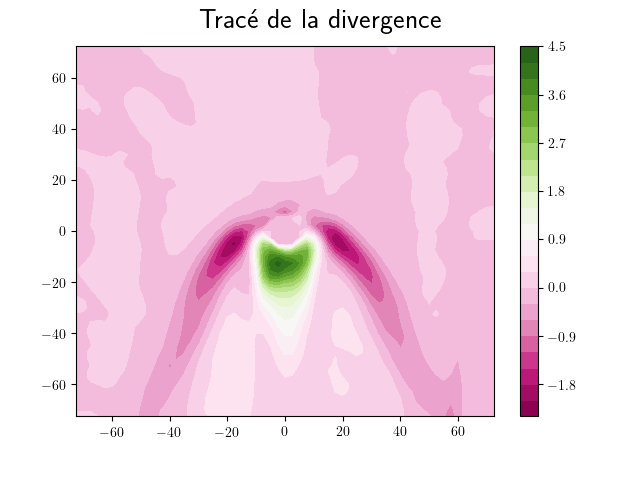

In [8]:
%matplotlib notebook
plan=2
plot_divergence(div_2D[plan],dx[plan],dy[plan],"Tracé de la divergence")

# Application de la méthode de Galerkine
## Choix du nombre de mode

In [9]:
m=5

## Construction des différents tableaux
### Tableau des z

In [10]:
#z=np.reshape(z,(P,1))
print(z)
print(np.shape(z))

[ 0.7  1.   1.3  1.6  1.9  2.2  2.5  2.8  3.1  3.4  3.7  4.   4.3  4.6
  4.9  5.2  5.5  5.8  6.1  6.4  6.7  7.   7.3  7.6  7.9  8.2  8.5  8.8
  9.1  9.4  9.7 10. ]
(32,)


### Matrice M

In [11]:
h=prof
M=np.transpose(np.array([n*np.pi/h*np.cos(n*np.pi/h*z) for n in range(1,m+1)]))

pinv=nppinv(M)
print(np.shape(pinv))

(5, 32)


# Résolution
## Coefficients

In [12]:
div_2D=np.reshape(div_2D,(P,59*59)) #Est-ce que ça marche vraiment ?? Sinon le produit matriciel ne fonctionne pas..

In [13]:
a=np.matmul(pinv,div_2D)
#a=np.reshape(a,(5,59,59))
print(np.shape(a))

(5, 3481)


## Détermination de v_z

In [14]:
sin=np.transpose(np.array([np.sin(m*np.pi*z/h) for m in range(1,m+1)]))
print(np.shape(sin))
vz=np.matmul(sin,a)
vz=np.reshape(vz,(P,59,59))
print(np.shape(vz))

(32, 5)
(32, 59, 59)


# Fonction Galerkine

In [15]:
def methode_Galerkine(u,v,x,y,z,P,m,h):
    "Applique la méthode Galerkine"
    #divergence bidimensionelle
    div_2D=np.zeros((P,59,59))
    dx=np.zeros((P,59,59))
    dy=np.zeros((P,59,59))
    for plan in range(P):
        div_2D[plan],dx[plan],dy[plan]=fpd.divergence2D_gauss(u[plan],v[plan],x[plan],y[plan],1)
    #Matrice pinv
    pinv=nppinv(np.transpose(np.array([n*np.pi/h*np.cos(n*np.pi/h*z) for n in range(1,m+1)])))
    #Calcul des coefficients
    div_2D=np.reshape(div_2D,(P,59*59))
    a=np.matmul(pinv,div_2D)
    #calcul de vz
    sin=np.transpose(np.array([np.sin(m*np.pi*z/h) for m in range(1,m+1)]))
    vz=np.matmul(sin,a)
    vz=np.reshape(vz,(P,59,59))
    return(vz)

# Tracé des champs de vitesse pour des plans à x ou y fixé.
## Remise à la bonne forme des tableaux

In [16]:
u=u[:,:-1,:-1]
v=v[:,:-1,:-1]
x=x[:,:-1,:-1]
y=y[:,:-1,:-1]
xmax=59
ymax=59

#tableau des z:
z1=np.reshape(z,(P,1))
z=np.hstack((z1,z1))
for i in range(xmax-2):
    z=np.hstack((z1,z))
print(np.shape(z))
print(np.shape(z))

(32, 59)
(32, 59)


## Tracé des champs de vitesse
### Fonction de plot

In [17]:
def plot_champ_vitesse(u,v,x,y,title,xlabel,ylabel):
    "Fonction de tracé du champ de vitesse"
    # Pour mieux les représenter, Clément bidouille la colormap
    velocity=np.sqrt(u**2+v**2)
    velmax=np.mean(velocity)+3*np.std(velocity)#norme maximale représentée sur la colormap borne sup arbitraire
    colors = velocity
    colors[velocity>velmax]=velmax
    # norm = Normalize()
    # norm.autoscale(colors)
    
    #nombre de flèches
    x=x[::2,:]
    y=y[::2,:]
    u=u[::2,:]
    v=v[::2,:]
    velocity=velocity[::2,:]
    
    #plot   
    fig,ax=plt.subplots(num=title)
    im=ax.quiver(x,y,u/velocity,v/velocity,colors)
    fig.colorbar(im, ax=ax)  #pour la barre de couleur
    
    fig.suptitle(title,fontsize=16)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.tight_layout(pad=3)
    plt.show()

### Champ de vitesse à x fixé

<IPython.core.display.Javascript object>


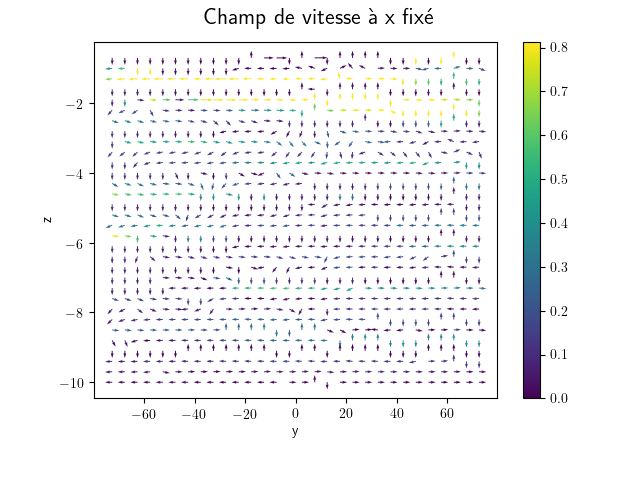

In [18]:
x=5 #Choix de x (x va de 0 à xmax)
plot_champ_vitesse(np.transpose(v[:,:,x]), np.transpose(vz[:,:,x]), np.transpose(dy[:,:,x]), -np.transpose(z), "Champ de vitesse à x fixé", "y", "z")
   

### Champ de vitesse à y fixé 

<IPython.core.display.Javascript object>


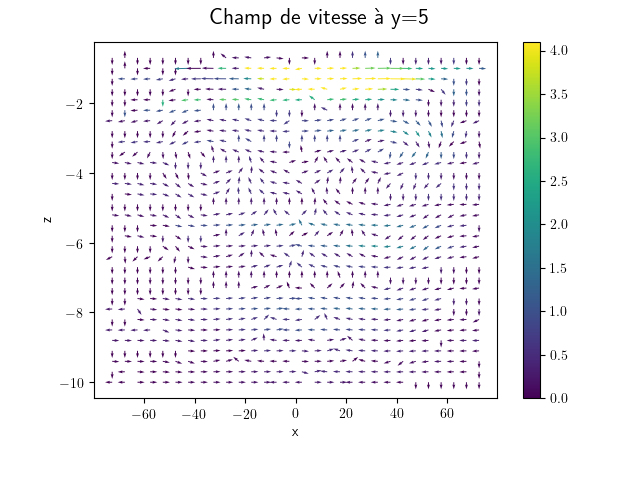

In [19]:
y=5 #Choix de y
plot_champ_vitesse(np.transpose(u[:,y,:]), np.transpose(vz[:,y,:]), np.transpose(dx[:,y,:]), -np.transpose(z), "Champ de vitesse à y={}".format(y), "x", "z")
